In [40]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import random

# Objective Function
## Pareto Frontier of Sharpe Ratio and ESG Score

The Sharpe Ratio is defined as:

$$
\text{Sharpe Ratio} = \frac{\sum_{i=1}^n w_i \mu_i - R_f}{\sqrt{w^T \Sigma w}}
$$

Where:
- $μ_i$ = Portfolio return  
- $R_f$ = Risk-free rate  
- $σ_p$ = Portfolio volatility (standard deviation)
- $Σw$	= Covariance matrix

In [12]:
# gather ticker info from Alpha Vantage API
API_KEY = "OD76BXNCWU9GO4WP"
symbols = ["MSFT", "AAPL", "NVDA", "UNH", "JNJ", "JPM", "V", "AMZN", "TSLA", "PG", 
           "KO", "HON", "UNP", "NEE", "CVX", "DUK", "PLD", "LIN", "GOOGL", "VZ"]
test = ["MSFT", "NVDA"]

weights = [0.3, 0.7]

esg_scores = [53,61]

def fetch_daily_prices(ticker):
    url = "https://www.alphavantage.co/query"
    params = {
        "function": "TIME_SERIES_DAILY",
        "symbol": ticker,
        "apikey": API_KEY,
        "outputsize": "full"
    }

    response = requests.get(url, params=params)
    data = response.json()

    # Check for valid time series key
    time_series_key = next((key for key in data if "Time Series" in key), None)
    if not time_series_key:
        print(f"[Error] No time series for {ticker}. Response: {data}")
        return pd.Series(dtype=float)  # Empty series

    df = pd.DataFrame(data[time_series_key]).T
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()
    df["close"] = df["4. close"].astype(float)

    return df["close"].iloc[-1260:]  # Last 5 years of trading days

def fetch_all_prices(symbols, output_file="daily_close_prices.csv"):
    all_prices = {}

    for i, symbol in enumerate(symbols):
        print(f"[{i+1}/{len(symbols)}] Fetching {symbol}...")
        all_prices[symbol] = fetch_daily_prices(symbol)

    df = pd.DataFrame(all_prices)
    df.to_csv(output_file)
    print(f"\n Saved data to {output_file}")
    return df

In [14]:

df_prices = fetch_all_prices(test)

[1/2] Fetching MSFT...
[2/2] Fetching NVDA...

 Saved data to daily_close_prices.csv


In [26]:
def evaluate_objectives(weights, prices_df, esg_vector, risk_free_rate=0.02):
    weights = np.array(weights)
    weights = np.clip(weights, 0, None)
    weights /= np.sum(weights)

    daily_returns = prices_df.pct_change().dropna()
    mean_daily_returns = daily_returns.mean()
    mean_annual_returns = (1 + mean_daily_returns) ** 252 - 1
    cov_matrix_annual = daily_returns.cov() * 252

    portfolio_return = np.dot(weights, mean_annual_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_annual, weights)))

    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    esg_score = np.dot(weights, esg_vector)

    return sharpe_ratio, esg_score

In [36]:
# ABC Algorithm

#Pareto Archive

def dominates(a, b):
    return all(x >= y for x, y in zip(a, b)) and any(x > y for x, y in zip(a, b))

def update_pareto_archive(archive, candidate_objectives, candidate_weights):
    new_archive = []
    dominated = False

    for (s, e, w) in archive:
        if dominates((s, e), candidate_objectives):
            dominated = True
            break
        elif not dominates(candidate_objectives, (s, e)):
            new_archive.append((s, e, w))  # keep it

    if not dominated:
        new_archive.append((*candidate_objectives, candidate_weights))

    return new_archive
def normalize_weights(w):
    w = np.clip(w, 0, None)
    return w / np.sum(w)

def initialize_population(num_bees, prices_df, esg_vector):
    num_assets = prices_df.shape[1]  # number of stocks

    foods = []
    objectives = []
    trials = np.zeros(num_bees)
    pareto_archive = []

    for _ in range(num_bees):
        # Step 1: Generate random weight vector
        weights = normalize_weights(np.random.rand(num_assets))

        # Step 2: Evaluate objectives (Sharpe, ESG)
        sharpe, esg = evaluate_objectives(weights, prices_df, esg_vector)

        # Step 3: Add to food list and objectives
        foods.append(weights)
        objectives.append((sharpe, esg))

        # Step 4: Update Pareto archive
        pareto_archive = update_pareto_archive(pareto_archive, (sharpe, esg), weights)

    return foods, objectives, trials, pareto_archive
    
def employed_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        # Step 1: Pick a random parameter (asset weight) to mutate
        param2change = random.randint(0, num_assets - 1)

        # Step 2: Pick a different random neighbor bee
        neighbour = random.randint(0, num_bees - 1)
        while neighbour == i:
            neighbour = random.randint(0, num_bees - 1)

        # Step 3: Generate new solution by ABC mutation formula
        phi = (random.random() - 0.5) * 2
        candidate = np.copy(foods[i])
        candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

        # Step 4: Clip and normalize the candidate
        candidate = np.clip(candidate, 0, None)
        candidate /= np.sum(candidate)

        # Step 5: Evaluate objectives
        new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

        # Step 6: Compare and decide
        if dominates(new_objectives, objectives[i]):
            # Accept new solution
            foods[i] = candidate
            objectives[i] = new_objectives
            trials[i] = 0
        else:
            trials[i] += 1  # No improvement

        # Step 7: Update Pareto archive regardless
        pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

    return foods, objectives, trials, pareto_archive

def compute_probabilities(objectives):
    sharpes = [s for s, e in objectives]
    esgs = [e for s, e in objectives]

    # Normalize to [0, 1]
    sharpes_norm = [(s - min(sharpes)) / (max(sharpes) - min(sharpes) + 1e-8) for s in sharpes]
    esgs_norm = [(e - min(esgs)) / (max(esgs) - min(esgs) + 1e-8) for e in esgs]

    # Combine them
    scores = [(0.5 * s + 0.5 * e) for s, e in zip(sharpes_norm, esgs_norm)]
    total = sum(scores)
    probabilities = [s / total for s in scores]
    return probabilities

def onlooker_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive):
    num_bees = len(foods)
    num_assets = len(foods[0])
    probabilities = compute_probabilities(objectives)

    i = 0
    t = 0
    while t < num_bees:
        if random.random() < probabilities[i]:
            t += 1

            # Mutation
            param2change = random.randint(0, num_assets - 1)
            neighbour = random.randint(0, num_bees - 1)
            while neighbour == i:
                neighbour = random.randint(0, num_bees - 1)

            phi = (random.random() - 0.5) * 2
            candidate = np.copy(foods[i])
            candidate[param2change] += phi * (foods[i][param2change] - foods[neighbour][param2change])

            candidate = np.clip(candidate, 0, None)
            candidate /= np.sum(candidate)

            new_objectives = evaluate_objectives(candidate, prices_df, esg_vector)

            if dominates(new_objectives, objectives[i]):
                foods[i] = candidate
                objectives[i] = new_objectives
                trials[i] = 0
            else:
                trials[i] += 1

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, candidate)

        i = (i + 1) % num_bees

    return foods, objectives, trials, pareto_archive

def scout_bee_phase(foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit=10):
    num_bees = len(foods)
    num_assets = len(foods[0])

    for i in range(num_bees):
        if trials[i] >= limit:
            # Replace this food source with a new random one
            new_weights = np.random.rand(num_assets)
            new_weights = new_weights / np.sum(new_weights)

            new_objectives = evaluate_objectives(new_weights, prices_df, esg_vector)

            foods[i] = new_weights
            objectives[i] = new_objectives
            trials[i] = 0  # reset trial count

            pareto_archive = update_pareto_archive(pareto_archive, new_objectives, new_weights)

    return foods, objectives, trials, pareto_archive
def plot_pareto_archive(archive, cycle):
    sharpes = [s for s, e, _ in archive]
    esgs = [e for s, e, _ in archive]

    plt.figure(figsize=(6, 4))
    plt.scatter(esgs, sharpes, alpha=0.6)
    plt.xlabel("ESG Score")
    plt.ylabel("Sharpe Ratio")
    plt.title(f"Pareto Frontier at Cycle {cycle}")
    plt.grid(True)
    plt.show()

def run_abc(prices_df, esg_vector, num_bees=20, max_cycles=100, limit=10, patience=15):
    # Init phase 
    foods, objectives, trials, pareto_archive = initialize_population(
        num_bees, prices_df, esg_vector
    )

    cycle = 0
    no_change_count = 0
    prev_archive_objs = set()

    while cycle < max_cycles and no_change_count < patience:
        # Employed Phase 
        foods, objectives, trials, pareto_archive = employed_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Onlooker Phase 
        foods, objectives, trials, pareto_archive = onlooker_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive
        )

        # Scout Phase 
        foods, objectives, trials, pareto_archive = scout_bee_phase(
            foods, objectives, trials, prices_df, esg_vector, pareto_archive, limit
        )

        # Plot Every 10 Cycles 
        if cycle % 10 == 0:
            plot_pareto_archive(pareto_archive, cycle)

        # Check for Convergence
        current_objs = set((round(s, 4), round(e, 4)) for s, e, _ in pareto_archive)
        if current_objs == prev_archive_objs:
            no_change_count += 1
        else:
            no_change_count = 0
            prev_archive_objs = current_objs

        cycle += 1

    return pareto_archive

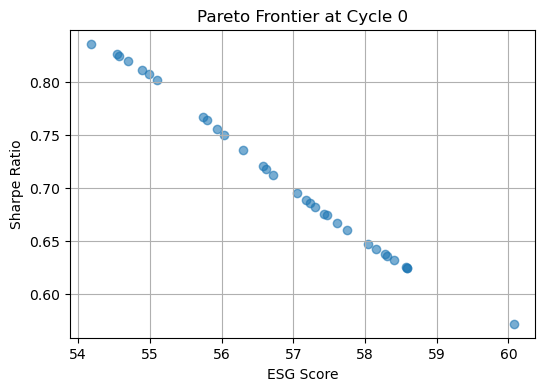

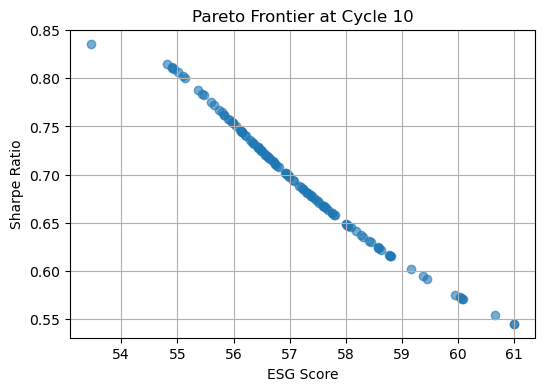

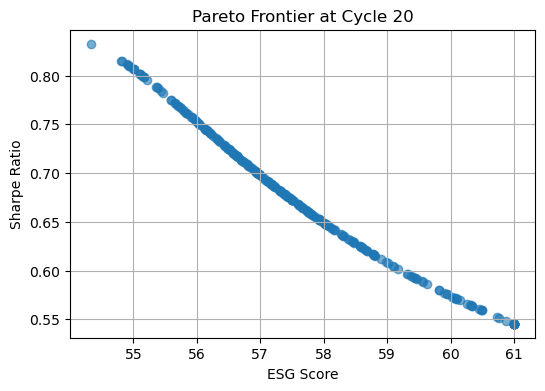

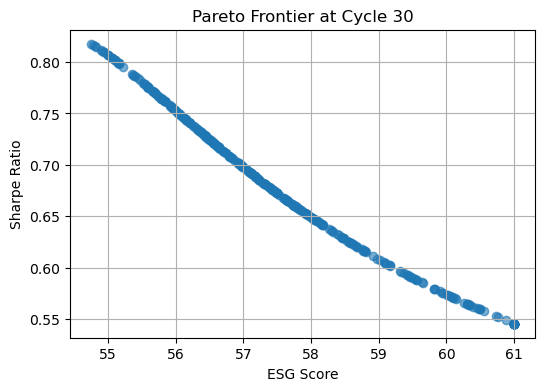

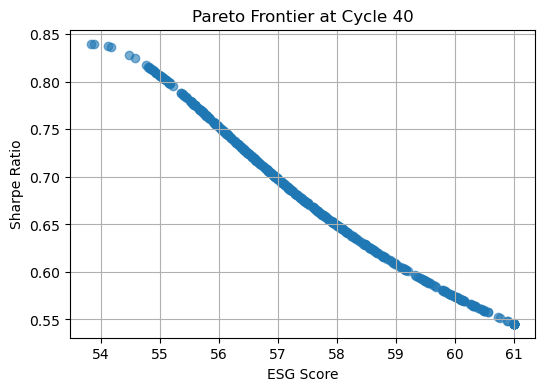

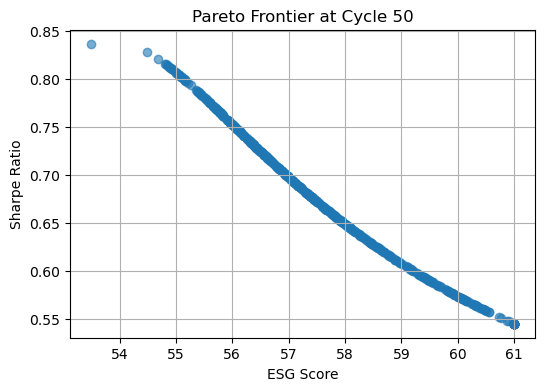

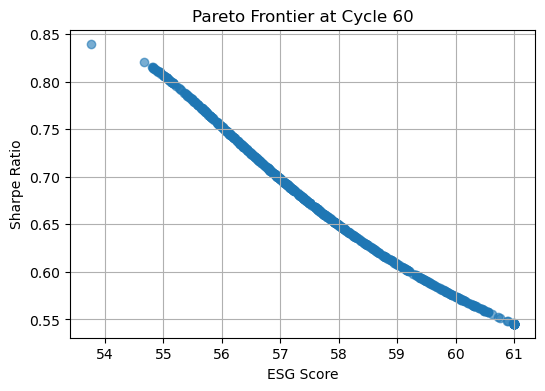

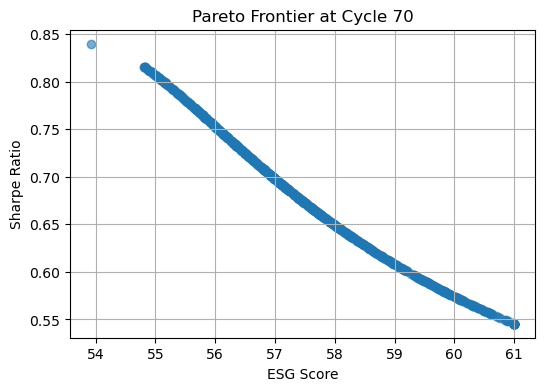

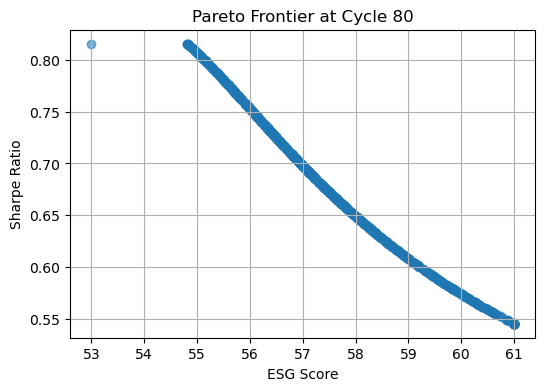

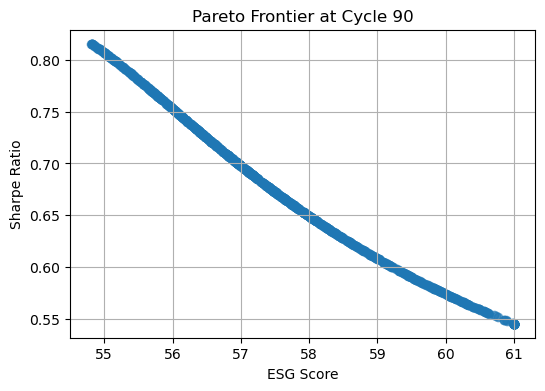

In [42]:
esg_vector = np.array(esg_scores)
pareto_test = run_abc(df_prices, esg_scores, num_bees = 20, max_cycles = 100, limit = 10, patience = 15)

In [50]:
sorted_by_sharpe = sorted(pareto_test, key=lambda x: x[0], reverse=True)
sorted_by_esg = sorted(pareto_test, key=lambda x: x[1], reverse=True)
for sharpe, esg, weights in sorted_by_sharpe:
    print(f"Sharpe: {sharpe:.3f}, ESG: {esg:.1f}, Weights: {np.round(weights, 2)}")
for sharpe, esg, weights in sorted_by_esg:
    print(f"Sharpe: {sharpe:.3f}, ESG: {esg:.1f}, Weights: {np.round(weights, 2)}")

Sharpe: 0.839, ESG: 54.0, Weights: [0.87 0.13]
Sharpe: 0.816, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.815, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.814, ESG: 54.8, Weights: [0.77 0.23]
Sharpe: 0.813, ESG: 54.9, Weights: [0.77 0.23]
Sharpe: 0.813, ESG: 54.9, Weights: [0.77 0.23]
Sharpe: 0.812, ESG: 54.9, Weights: [0.77 0.23]
Sharpe: 0.812, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.811, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.811, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.810, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.810, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.810, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.810, ESG: 54.9, Weights: [0.76 0.24]
Sharpe: 0.809, ESG: 55.0, Weights: [0.76 0.24]
Sharpe: 0.808

In [52]:
def display_archive(archive, title="Pareto Archive (Sorted)"):
    print(f"\n{title}")
    print("-" * 50)
    for i, (sharpe, esg, weights) in enumerate(archive):
        w_str = ", ".join(f"{w:.2f}" for w in weights)
        print(f"[{i+1}] Sharpe: {sharpe:.4f} | ESG: {esg:.2f} | Weights: [{w_str}]")
display_archive(sorted_by_sharpe, title="Top Portfolios by Sharpe")



Top Portfolios by Sharpe
--------------------------------------------------
[1] Sharpe: 0.8389 | ESG: 54.03 | Weights: [0.87, 0.13]
[2] Sharpe: 0.8156 | ESG: 54.81 | Weights: [0.77, 0.23]
[3] Sharpe: 0.8153 | ESG: 54.81 | Weights: [0.77, 0.23]
[4] Sharpe: 0.8152 | ESG: 54.82 | Weights: [0.77, 0.23]
[5] Sharpe: 0.8152 | ESG: 54.82 | Weights: [0.77, 0.23]
[6] Sharpe: 0.8150 | ESG: 54.82 | Weights: [0.77, 0.23]
[7] Sharpe: 0.8149 | ESG: 54.82 | Weights: [0.77, 0.23]
[8] Sharpe: 0.8149 | ESG: 54.82 | Weights: [0.77, 0.23]
[9] Sharpe: 0.8146 | ESG: 54.83 | Weights: [0.77, 0.23]
[10] Sharpe: 0.8140 | ESG: 54.84 | Weights: [0.77, 0.23]
[11] Sharpe: 0.8134 | ESG: 54.86 | Weights: [0.77, 0.23]
[12] Sharpe: 0.8130 | ESG: 54.87 | Weights: [0.77, 0.23]
[13] Sharpe: 0.8125 | ESG: 54.88 | Weights: [0.77, 0.23]
[14] Sharpe: 0.8116 | ESG: 54.90 | Weights: [0.76, 0.24]
[15] Sharpe: 0.8110 | ESG: 54.91 | Weights: [0.76, 0.24]
[16] Sharpe: 0.8107 | ESG: 54.92 | Weights: [0.76, 0.24]
[17] Sharpe: 0.8102 